# Проба на основе "Случайный лес".

In [16]:
from pathlib import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
from sklearn.model_selection import train_test_split
import scipy as sp
from sklearn.ensemble import RandomForestClassifier
import pickle
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import metrics
from matplotlib.legend_handler import HandlerLine2D
from sklearn.tree import export_graphviz
import graphviz

## Очистка и подготовка данных

Загрузим данные и посмотрим на них

In [17]:
df = pd.read_csv(
        Path('c:\data_quote\data_prepare_RTS_range_mvc_tpsl_sec\SPFB.RTS_00_range250_splice_2022.txt'),
        delimiter=','
    )
print("Количество наблюдений: ", df.shape[0])
print("Количество атрибутов: ", df.shape[1])

df.drop(labels=['<DATE>', '<VOL>'], axis=1, inplace=True)  # Убираем ненужные колонки
df.rename(columns={'<MAX_VOLUME_CLUSTER>': '<MAX_VOL>'}, inplace=True)  # Переименование колонки

# Настройки отображения DF
# pd.set_option('max_rows', 5)  # Установка 5 строк вывода DF
pd.set_option('display.max_columns', None)  # Сброс ограничений на показ числа столбцов

df

Количество наблюдений:  12778
Количество атрибутов:  12


,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<MAX_VOLUME_PRICE>,<MAX_VOL>,<TP_SL>,<SEC>,<PER>
0,70000,159950.0,160200.0,159950.0,160200.0,159970.0,135,1,1,0.08
1,70001,160600.0,160960.0,160710.0,160710.0,160960.0,121,3,1,0.00
2,70002,160700.0,160730.0,160480.0,160480.0,160600.0,147,3,4,0.52
3,70006,160470.0,160600.0,160350.0,160350.0,160510.0,350,3,63,0.36
4,70109,160340.0,160510.0,160260.0,160260.0,160370.0,212,3,275,0.56
...,...,...,...,...,...,...,...,...,...,...
12773,232158,144950.0,145170.0,144920.0,145170.0,145050.0,263,0,638,0.52
12774,233236,145180.0,145370.0,145120.0,145120.0,145330.0,227,0,317,0.16
12775,233753,145110.0,145200.0,144950.0,144950.0,145100.0,247,-1,433,0.40
12776,234506,144940.0,145180.0,144930.0,145180.0,145080.0,89,0,135,0.60


In [18]:
# Дальнейшая очистка данных
df = df.loc[df['<TP_SL>'] != 0]  # Убираем строки где <TP_SL> равен 0
df = df.loc[df['<HIGH>'] > df['<MAX_VOLUME_PRICE>']]
df = df.loc[df['<MAX_VOLUME_PRICE>'] > df['<LOW>']]
df.drop(labels=['<MAX_VOLUME_PRICE>'], axis=1, inplace=True)  # Убираем ненужные колонки

print("Количество наблюдений: ", df.shape[0])
print("Количество атрибутов: ", df.shape[1])

df

Количество наблюдений:  12416
Количество атрибутов:  9


,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<MAX_VOL>,<TP_SL>,<SEC>,<PER>
0,70000,159950.0,160200.0,159950.0,160200.0,135,1,1,0.08
2,70002,160700.0,160730.0,160480.0,160480.0,147,3,4,0.52
3,70006,160470.0,160600.0,160350.0,160350.0,350,3,63,0.36
4,70109,160340.0,160510.0,160260.0,160260.0,212,3,275,0.56
5,70544,160250.0,160280.0,160030.0,160030.0,1013,3,36,0.52
...,...,...,...,...,...,...,...,...,...
12769,214132,145300.0,145310.0,145060.0,145060.0,850,1,1891,0.44
12770,221303,145050.0,145220.0,144970.0,144970.0,992,-1,3323,0.48
12771,230826,144960.0,145010.0,144760.0,144760.0,310,-1,371,0.44
12772,231437,144750.0,144940.0,144690.0,144940.0,188,1,441,0.28


In [19]:
def change_tp(cell, tp: int):
    """ Преобразует значение ТП в зависимости от выбора ТП"""
    if tp == 1:
        if cell in [2, 3]:
            return 1
        else:
            return cell
    elif tp == 2:
        if cell == 3:
            return 2
        elif cell == 1:
            return -1
        else:
            return cell
    elif tp == 3:
        if cell in [1, 2]:
            return -1
        else:
            return cell
    else:
        return cell
    
    
TP = 1  # Выбираем ТП=СЛ
# TP = 2  # Выбираем 2*ТП=СЛ
# TP = 3  # Выбираем 3*ТП=СЛ
df['<TP_SL>'] = df.apply(lambda x: change_tp(x['<TP_SL>'], TP), axis=1)  # Преобразование значений под выбранный ТП
df

,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<MAX_VOL>,<TP_SL>,<SEC>,<PER>
0,70000,159950.0,160200.0,159950.0,160200.0,135,1.0,1,0.08
2,70002,160700.0,160730.0,160480.0,160480.0,147,1.0,4,0.52
3,70006,160470.0,160600.0,160350.0,160350.0,350,1.0,63,0.36
4,70109,160340.0,160510.0,160260.0,160260.0,212,1.0,275,0.56
5,70544,160250.0,160280.0,160030.0,160030.0,1013,1.0,36,0.52
...,...,...,...,...,...,...,...,...,...
12769,214132,145300.0,145310.0,145060.0,145060.0,850,1.0,1891,0.44
12770,221303,145050.0,145220.0,144970.0,144970.0,992,-1.0,3323,0.48
12771,230826,144960.0,145010.0,144760.0,144760.0,310,-1.0,371,0.44
12772,231437,144750.0,144940.0,144690.0,144940.0,188,1.0,441,0.28


In [20]:
# Статистика по данным
description = df.describe(include='all')
description.to_excel("data_stat.xlsx")
description

,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<MAX_VOL>,<TP_SL>,<SEC>,<PER>
count,12416.000000,12416.000000,12416.000000,12416.000000,12416.000000,12416.000000,12416.000000,12416.000000,12416.000000
mean,135277.572245,141858.267558,141982.802835,141732.802835,141856.816205,222.533827,0.003705,99.704494,0.452535
std,42950.230426,8995.775119,8995.299561,8995.299561,8994.363379,198.056551,1.000033,186.880697,0.211550
min,70000.000000,125730.000000,125970.000000,125720.000000,125820.000000,1.000000,-1.000000,1.000000,0.040000
25%,101500.000000,133860.000000,133970.000000,133720.000000,133850.000000,95.000000,-1.000000,16.000000,0.280000
50%,130911.000000,141350.000000,141480.000000,141230.000000,141350.000000,167.000000,1.000000,40.000000,0.440000
75%,171013.250000,147670.000000,147820.000000,147570.000000,147672.500000,284.250000,1.000000,101.000000,0.600000
max,234921.000000,163720.000000,163860.000000,163610.000000,163710.000000,3156.000000,1.000000,3323.000000,0.960000


In [21]:
print("Количество пустых значений:")
print(df.isnull().sum())

Количество пустых значений:
<TIME>       0
<OPEN>       0
<HIGH>       0
<LOW>        0
<CLOSE>      0
<MAX_VOL>    0
<TP_SL>      0
<SEC>        0
<PER>        0
dtype: int64


Посмотрим на сбаллансированность ТП_СЛ

50.18524484536082 процентов ТП


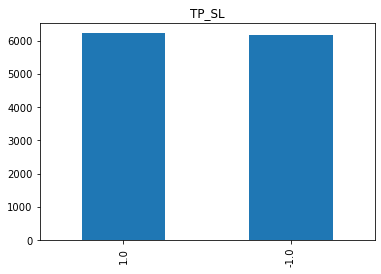

In [22]:
print(f"{df['<TP_SL>'][df['<TP_SL>']==1].count()/df['<TP_SL>'].count()*100} процентов ТП")
# TP_SL тейк-профит и стоп-лосс
df['<TP_SL>'].value_counts().plot(kind='bar')
plt.title("TP_SL")
plt.show()

In [23]:
# Оставляем только бары на повышение
df = df.loc[df['<HIGH>'] == df['<CLOSE>']]
df

,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<MAX_VOL>,<TP_SL>,<SEC>,<PER>
0,70000,159950.0,160200.0,159950.0,160200.0,135,1.0,1,0.08
9,71414,159500.0,159690.0,159440.0,159690.0,358,-1.0,165,0.24
11,72215,159530.0,159650.0,159400.0,159650.0,350,-1.0,346,0.48
13,73118,159460.0,159560.0,159310.0,159560.0,380,-1.0,342,0.56
15,74709,159330.0,159450.0,159200.0,159450.0,365,1.0,595,0.20
...,...,...,...,...,...,...,...,...,...
12765,204127,144620.0,144790.0,144540.0,144790.0,364,1.0,818,0.32
12766,205505,144800.0,144900.0,144650.0,144900.0,609,1.0,1284,0.60
12767,211629,144910.0,145100.0,144850.0,145100.0,704,-1.0,1284,0.24
12768,213753,145110.0,145290.0,145040.0,145290.0,765,-1.0,219,0.64


49.99188179899334 процентов ТП


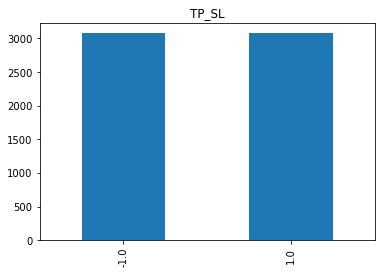

In [24]:
print(f"{df['<TP_SL>'][df['<TP_SL>']==1].count()/df['<TP_SL>'].count()*100} процентов ТП")
# TP_SL тейк-профит и стоп-лосс
df['<TP_SL>'].value_counts().plot(kind='bar')
plt.title("TP_SL")
plt.show()

Разделим данные на "Х" и "у". На класс который нужно предсказать('y') и на все аттрибуты('X').

In [27]:
y = df['<TP_SL>'].eq(1).astype(int)  # Классы переводим в численное значение "Yes" - 1, "No" - 0
X = df.drop(labels=['<TP_SL>', '<TIME>', '<OPEN>', '<HIGH>', '<LOW>',  '<CLOSE>'], axis=1)  # Из "Х" убираем колонку классов "у"

In [29]:
# корреляция между атрибутами
corr = X.corr()
corr.to_excel("correlations.xlsx")

In [31]:
# нижний треугольник матрицы
triangle = corr.abs().where(np.tril(np.ones(corr.shape), k=-1).astype(np.bool_))

In [32]:
print("Самая сильная корреляция:")
print(triangle.stack().sort_values(ascending=False)[:10])

Самая сильная корреляция:
<SEC>  <MAX_VOL>    0.409447
<PER>  <SEC>        0.055535
       <MAX_VOL>    0.043531
dtype: float64


## Обучение классификатора

In [33]:
# разделим данные на две части: 30% отложим для тестирования
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=47)

In [34]:
clf = RandomForestClassifier(random_state=47, n_jobs=-1, n_estimators=100, class_weight='balanced_subsample')

In [35]:
filename = 'rf_model.sav'

In [36]:
# Само обучение
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

print("Результат на тестовых данных (модель по умолчанию): %f" % (100*metrics.balanced_accuracy_score(y_test, y_pred)))

Результат на тестовых данных (модель по умолчанию): 49.242424


Проверим можем ли улучшить результат подбором гиперпараметров

In [38]:
param_distributions = {"max_features": list(range(1,X.shape[1])), "max_depth": list(range(3, 30))}

randomized_search = RandomizedSearchCV(
    clf, 
    param_distributions=param_distributions, 
    n_iter=60, 
    cv=5, 
    scoring="balanced_accuracy", 
    n_jobs=-1, 
    random_state=47
)

randomized_search.fit(X_train, y_train)
model = randomized_search.best_estimator_
# print("Оптимальные параметры: %s, оценка на учебных данных: %0.2f" % (randomized_search.best_params_, randomized_search.best_score_))
print(f"Оптимальные параметры: {randomized_search.best_params_}, "
      f"оценка на учебных данных: {randomized_search.best_score_:.2f}")

# сохраним обученную модель
pickle.dump(model, open(filename, 'wb'))

C:\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 54 is smaller than n_iter=60. Running 54 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Оптимальные параметры: {'max_features': 2, 'max_depth': 19}, оценка на учебных данных: 0.52


Проверим результат на тестовых данных.

In [39]:
model = pickle.load(open(filename, 'rb'))
y_pred = model.predict(X_test)

print("Результат на тестовых данных: %f" % (100*metrics.balanced_accuracy_score(y_test, y_pred)))

Результат на тестовых данных: 49.621212


Матрица неточностей

Матрица неточностей:
[[451 473]
 [458 466]]


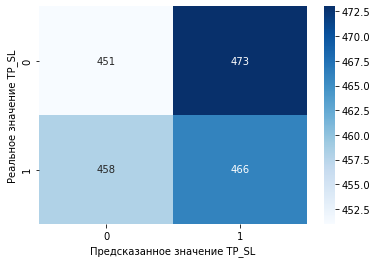

In [41]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

print("Матрица неточностей:")
print(cnf_matrix)

sb.heatmap(cnf_matrix, annot=True, cmap='Blues', fmt='g')
plt.ylabel('Реальное значение TP_SL')
plt.xlabel('Предсказанное значение TP_SL')
plt.show()

Информативность (важность) атрибутов

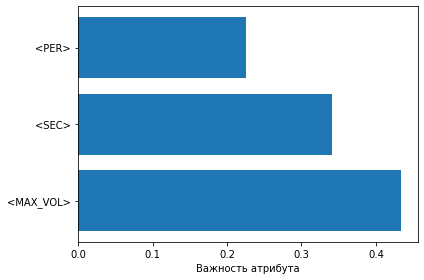

In [42]:
# информативность (важность) атрибутов

n_features = X.shape[1]
plt.barh(range(n_features), model.feature_importances_)
plt.yticks(np.arange(n_features), X.columns.values.tolist())
plt.xlabel("Важность атрибута")
plt.tight_layout()
plt.show()